<a href="https://colab.research.google.com/github/Messham87/COVID_GAT/blob/master/COVID_Graph_Setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, Dict, Union, List
from json import dumps
from requests import get
from http import HTTPStatus
import pickle

In [6]:
#pickle features 
def picklefile(tofile, content):
  outfile = open(tofile,'wb')
  pickle.dump(content, outfile)
  outfile.close()

In [7]:
def unpicklefile(fromfile):
  infile = open(fromfile,'rb')
  unpickled = pickle.load(infile)
  infile.close()
  return unpickled

In [8]:
#Get the coronavirus data from gov.uk
StructureType = Dict[str, Union[dict, str]]
FiltersType = Iterable[str]
APIResponseType = Union[List[StructureType], str]


def get_paginated_dataset(filters: FiltersType, structure: StructureType,
                          as_csv: bool = False) -> APIResponseType:
    """
    Extracts paginated data by requesting all of the pages
    and combining the results.

    Parameters
    ----------
    filters: Iterable[str]
        API filters. See the API documentations for additional
        information.

    structure: Dict[str, Union[dict, str]]
        Structure parameter. See the API documentations for
        additional information.

    as_csv: bool
        Return the data as CSV. [default: ``False``]

    Returns
    -------
    Union[List[StructureType], str]
        Comprehensive list of dictionaries containing all the data for
        the given ``filters`` and ``structure``.
    """
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"

    api_params = {
        "filters": str.join(";", filters),
        "structure": dumps(structure, separators=(",", ":")),
        "format": "json" if not as_csv else "csv"
    }

    data = list()

    page_number = 1

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = get(endpoint, params=api_params, timeout=20)

        if response.status_code >= HTTPStatus.BAD_REQUEST:
            raise RuntimeError(f'Request failed: {response.text}')
        elif response.status_code == HTTPStatus.NO_CONTENT:
            break

        if as_csv:
            csv_content = response.content.decode()

            # Removing CSV header (column names) where page 
            # number is greater than 1.
            if page_number > 1:
                data_lines = csv_content.split("\n")[1:]
                csv_content = str.join("\n", data_lines)

            data.append(csv_content.strip())
            page_number += 1
            continue

        current_data = response.json()
        page_data: List[StructureType] = current_data['data']
        
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1

    if not as_csv:
        return data

    # Concatenating CSV pages
    return str.join("\n", data)


if __name__ == "__main__":
    query_filters = [
        f"areaType=ltla"
    ]

    query_structure = {
        "date": "date",
        "name": "areaName",
        "code": "areaCode",
        "dailycases": "newCasesBySpecimenDate",
        "cumulativecases": "cumCasesBySpecimenDate",
        "dailydeaths": "newDeaths28DaysByPublishDate",
        "cumulativedeaths": "cumDeaths28DaysByPublishDate"
    }

    json_data = get_paginated_dataset(query_filters, query_structure)
    print("JSON:")
    print(f"Length:", len(json_data))
    print("Data (first 3 items):", json_data[:3])

    print("---" * 10)

JSON:
Length: 183634
Data (first 3 items): [{'date': '2021-07-03', 'name': 'Hartlepool', 'code': 'E06000001', 'dailycases': None, 'cumulativecases': None, 'dailydeaths': 0, 'cumulativedeaths': 251}, {'date': '2021-07-02', 'name': 'Hartlepool', 'code': 'E06000001', 'dailycases': 14, 'cumulativecases': 9613, 'dailydeaths': 0, 'cumulativedeaths': 251}, {'date': '2021-07-01', 'name': 'Hartlepool', 'code': 'E06000001', 'dailycases': 79, 'cumulativecases': 9599, 'dailydeaths': 0, 'cumulativedeaths': 251}]
------------------------------


In [9]:
#change json data into data frame
covid = pd.DataFrame.from_dict(json_data)

In [10]:
covid

,date,name,code,dailycases,cumulativecases,dailydeaths,cumulativedeaths
0,2021-07-03,Hartlepool,E06000001,NaN,NaN,0.0,251.0
1,2021-07-02,Hartlepool,E06000001,14.0,9613.0,0.0,251.0
2,2021-07-01,Hartlepool,E06000001,79.0,9599.0,0.0,251.0
3,2021-06-30,Hartlepool,E06000001,78.0,9520.0,0.0,251.0
4,2021-06-29,Hartlepool,E06000001,78.0,9442.0,0.0,251.0
...,...,...,...,...,...,...,...
183629,2020-03-20,Merthyr Tydfil,W06000024,0.0,3.0,NaN,NaN
183630,2020-03-19,Merthyr Tydfil,W06000024,1.0,3.0,NaN,NaN
183631,2020-03-18,Merthyr Tydfil,W06000024,0.0,2.0,NaN,NaN
183632,2020-03-17,Merthyr Tydfil,W06000024,0.0,2.0,NaN,NaN


In [11]:
cov2 = covid.set_index(["date", "name", "code"])

In [12]:
cov3 = cov2.stack().reset_index()

In [13]:
cov3.columns = ['date', 'name', 'code', 'columns', 'value']

In [14]:
decdeaths = cov3[(cov3["columns"] == "dailydeaths") & (cov3["date"] >= '2020-12-01')  & (cov3["date"] <= '2020-12-08')]

In [15]:
deccases = cov3[(cov3["columns"] == "dailycases") & (cov3["date"] >= '2020-12-01')  & (cov3["date"] <= '2020-12-08')]

In [16]:
deathpiv = decdeaths.pivot_table(index = ["code"], columns = "date", values = "value")

In [17]:
casepiv = deccases.pivot_table(index = ["code"], columns = "date", values = "value")

In [18]:
features = casepiv.merge(deathpiv, how = "left", on = ["code"])

In [19]:
features.index = features.index.map(mapping)

NameError: ignored

In [ ]:
features.sort_index(inplace=True)

In [ ]:
features = features[~features.index.isna()]

In [ ]:
# y = features["2020-12-08_x"]

In [ ]:
features = features.drop(["2020-12-08_y"], axis = 1).reset_index()

In [ ]:
cols = features.columns.to_list()

In [ ]:
cols

In [ ]:
cols = cols[:8] + cols[10:] + cols[8:9]

In [ ]:
features = features[cols]

In [ ]:
features

In [ ]:
#pickle features 
picklefile('idx_features_y',features)

In [ ]:
##THIS NEEDS TO BE RESOLVED
nodemap[nodemap.Code == 'E09000033']

In [ ]:
#select locations
cvlocs = covid[["name", "code"]].drop_duplicates()

##WICID DATA

In [ ]:
# #mount google drive to 
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [4]:
#locate the directory with local files
%cd /content/drive/MyDrive/COVID_GAT

/content/drive/MyDrive/COVID_GAT


In [ ]:
#Bring in WICID OA:OA usual residence to place of work, first and last two rows are not data so remove
OD = pd.read_csv('wicid_output-2.csv', skiprows = 2).iloc[1:-3,0:3]
len(OD)

In [ ]:
#Key from Census 11 OA to 2020 LA
lu = pd.read_csv('NSPCL_FEB20_UK_LU.csv', encoding='latin-1')

In [ ]:
#select required columns
lus = lu[["oa11cd", "ladcd", "ladnm"]].drop_duplicates()

In [ ]:
#OA to LA from WICID docs
LAs = pd.read_csv('OAtoLA.csv')

In [ ]:
#due to comma separation, some names have gone over two columns (i.e. City of London, Westminster) so find these columns. 
#Fortunately the right hand columns are not to be used so no further rearrangement required.
LAerrors = LAs[~LAs["to_label"].str.contains("0|9")].drop_duplicates()

In [ ]:
#Concatenate name and to_label column to new concat column with comma
LAerrors2 = LAerrors[["lad", "to_label"]].drop_duplicates().reset_index()
LAerrors2["Concat"] = LAerrors2["lad"]+","+LAerrors2["to_label"]

In [ ]:
#Replace lad with new concat columns for erroneous names
for i in range(len(LAerrors2)):
  LAs["lad"] = LAs["lad"].replace(LAerrors2["lad"][i], LAerrors2["Concat"][i])

In [ ]:
#Select just OA and name and drop duplicates to select just one OA for every Local Authority
LAs2 = LAs[["oa", "lad"]].drop_duplicates(subset = "lad", keep = "first")

In [ ]:
#Merge WICID data origins and destinations with above oa's and la's to give OA to LA name
Or_LA = OD.merge(LAs2, how = "left", left_on = "Origins", right_on = "lad").merge(LAs2, how = "left", left_on = "Destinations", right_on = "lad")

In [ ]:
#merge lookup table to oa for origin and destination to get current Local Authority name and code from census 11 codes
all = Or_LA.merge(lus, how = "left", left_on = "oa_x", right_on = "oa11cd").merge(lus, how = "left", left_on = "oa_y", right_on = "oa11cd")

In [ ]:
all.columns = ['Origins', 'Destinations',
       'Travel',
       'oa_Origin', 'lad_Origin', 'oa_Dest', 'lad_Dest', 'oa11cd_Origin', 'ladcd_Origin', 'ladnm_Origin',
       'oa11cd_Dest', 'ladcd_Dest', 'ladnm_Dest']

In [ ]:
#Check number of origins from WICID data - 404
print("Number of unique Origins in all from WICID data is: {}".format(len(all["Origins"].unique())))
#Check number of origins (names and codes) from lookup table - 380
print("Number of unique Origins names in all from Lookup table is: {}".format(len(all["ladnm_Origin"].unique())))
print("Number of unique Origins codes in all from Lookup table is: {}".format(len(all["ladcd_Origin"].unique())))
#Why the discrepency?
#Check how many origins in original wicid dataset - 404
print("Number of unique Origins in WICID data is: {}".format(len(OD["Origins"].unique())))
#Check how many codes in 2020 codes - 385
print("Number of unique 2020 codes in Lookup table is: {}".format(len(lus["ladcd"].unique())))
#Check how many codes in covid data - 380
print("Number of unique codes in covid data is: {}".format(len(cvlocs["code"].unique())))

In [ ]:
#Which codes are contributing to the extra 5 local authorities in the look up?
lus[["ladcd","ladnm"]][~lus["ladcd"].isin(cvlocs["code"])].drop_duplicates()

In [ ]:
#Are there any codes in covid data that are not covered by a lookup code?
cvlocs[~cvlocs["code"].isin(lus["ladcd"])].drop_duplicates()
#There are no codes in covid data that do not have contributing codes in lookups, are any local authorities in origins/destinations without a 2020 code?

In [ ]:
#Select origins with the same 2020 codes as other origins
dups = all[["Origins", "ladcd_Origin", "ladnm_Origin"]].drop_duplicates()[all["ladcd_Origin"].duplicated()].sort_values("ladcd_Origin")

In [ ]:
#How many codes share a 2020 code?
print("There are {} unique Origins that share a 2020 code".format(len(dups)))
#24, therefore all Origins have a 2020 code, this will require summing up of WICID data but there are no gaps in this data compared to covid data

In [ ]:
#Data check to ensure all WICID data (OD) have been maintained throught merges
print("The number of rows from WICID data match the final number of rows: {}".format(len(all) == len(OD)))

In [ ]:
pops = pd.read_excel('Mid-2011-unformatted-syoa-data-file.xls', sheet_name = 'Mid-2011 Persons')
pops2 = pops.groupby('Name').sum().reset_index()
len(pops2)

In [ ]:
#Check city of london westminster have correctly summed up
pops2[pops2['Name']=='City of London,Westminster']
#Correct

In [ ]:
allpops = all[['Origins','ladcd_Origin', 'ladnm_Origin',
     'ladcd_Dest', 'ladnm_Dest', 'Travel']].merge(pops2[["Name", " ALL AGES"]], how = 'left', left_on = 'Origins', right_on = 'Name')

In [ ]:
#manually change excel source to match 
#copied here for posterity
#['Dumfries & Galloway', 'Perth & Kinross',
#  'Cornwall,Isles of Scilly', 'City of London,Westminster',
#  'Argyll & Bute', 'Rhondda Cynon Taf', 'Herefordshire, County of']
#allpops["Origins"][allpops[" ALL AGES"].isna()].unique()
#City of London, Westminster and Cornwall,Isles of Scilly are separate in the population file so must be combined in population before being joined to all

In [ ]:
#Check all origins have a population now
allpops["Origins"][allpops[" ALL AGES"].isna()].unique()

In [ ]:
#Combine travel and all ages by origin and destination
#Change travel (string) to int
allpops["Travel"] = allpops["Travel"].astype(int)
combOD = allpops[["ladcd_Origin", "ladcd_Dest", "Travel", " ALL AGES"]].groupby(["ladcd_Origin", "ladcd_Dest"]).sum().reset_index()

In [ ]:
#Check number of origins in combined data
print("Number of unique Origins in combined data is: {}".format(len(combOD["ladcd_Origin"].unique())))

In [ ]:
#Bring in 2019 population density data
popdens19 = pd.read_excel('ukmidyearestimates20192020ladcodes.xls', sheet_name = 'MYE 5', skiprows = 4).iloc[:-2,:]

In [ ]:
#Join population data to combined data and rename columns
plus19 = combOD.merge(popdens19[["Code", "Estimated Population mid-2019"]], how = "left", left_on = "ladcd_Origin", right_on = "Code")
plus19.columns = ["Origin", "Destination", "Travel", "11_Pop", "Code", "19_Pop"]

In [ ]:
#bring in 2019 population data by age
pop19 = pd.read_excel('ukmidyearestimates20192020ladcodes.xls', sheet_name = 'MYE2 - Persons', skiprows = 4).iloc[:-2,:]

In [ ]:
#Travel percentage - multiply travel from 11 census by 19 population / 11 population to get 2019 travel estimates 
# to get a percentage of origin node that travels to destination
plus19["TravPerc"] = 100*((plus19["Travel"]*(plus19["19_Pop"]/plus19["11_Pop"]))/plus19["19_Pop"])

In [ ]:
len(plus19["Origin"].unique())

In [ ]:
len(plus19["Destination"].unique())

In [ ]:
#Edge definition - if 0.1% or more of the node population travel to the destination node
filtnodes = plus19[["Origin","Destination"]][(plus19["TravPerc"]>=0.1)].reset_index(drop = True) #& (plus19["Origin"]!=plus19["Destination"])]

In [ ]:
len(filtnodes[["Origin", "Destination"]].drop_duplicates())

In [ ]:
pd.DataFrame(np.vstack((filtnodes[["Origin", "Destination"]].values, filtnodes[["Destination", "Origin"]].values))).drop_duplicates()

In [ ]:
print("There are {} unique Origin nodes and {} unique Destination nodes".format(len(filtnodes["Origin"].unique()), len(filtnodes["Destination"].unique())))

In [ ]:
# #Create mapping of nodes to an index
nodemap = pd.DataFrame(np.hstack([filtnodes["Origin"], filtnodes["Destination"]])).drop_duplicates().reset_index(drop = True).reset_index()

In [ ]:
nodemap[nodemap.iloc[:,1]=='E09000033']

In [ ]:
# #rename columns
nodemap.columns = ["ValInd", "Code"]

In [ ]:
#pickle nodemap for posterity
picklefile('nodemap', nodemap)

In [ ]:
nodemap = unpickle('nodemap')

In [ ]:
nodemap

In [ ]:
#map nodenums to filtnodes to create indexed columns
mapping = dict(zip(nodemap.Code, nodemap.ValInd))
nodenums = pd.DataFrame()
nodenums["Origin"] = filtnodes.Origin.map(mapping)
nodenums["Destination"] = filtnodes.Destination.map(mapping)
nodenums = nodenums.to_numpy()

In [ ]:
picklefile('edge_list', nodenums)

In [ ]:
# for i in range(len(filtnodes)):
#   for j in range(len(a)):
#     if filtnodes.loc[i,"Origin"] == a.loc[j,"Code"]:
#       filtnodes.loc[i,"Origin"] = a.loc[j,"ValInd"]
#     if filtnodes.loc[i,"Destination"] == a.loc[j,"Code"]:
#       filtnodes.loc[i,"Destination"] = a.loc[j,"ValInd"]

In [ ]:
#create networkx graph
G = nx.Graph()

In [ ]:
#populate nodes from dataframe
G = nx.from_pandas_edgelist(filtnodes, 'Origin', 'Destination')

In [ ]:
mapping

In [ ]:
filtnodes[filtnodes.index == 5478]

,Origin,Destination
5478,E09000017,E07000005


In [ ]:
mapping.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [ ]:
G = nx.from_pandas_edgelist(nodenums,source='Origin',target='Destination')

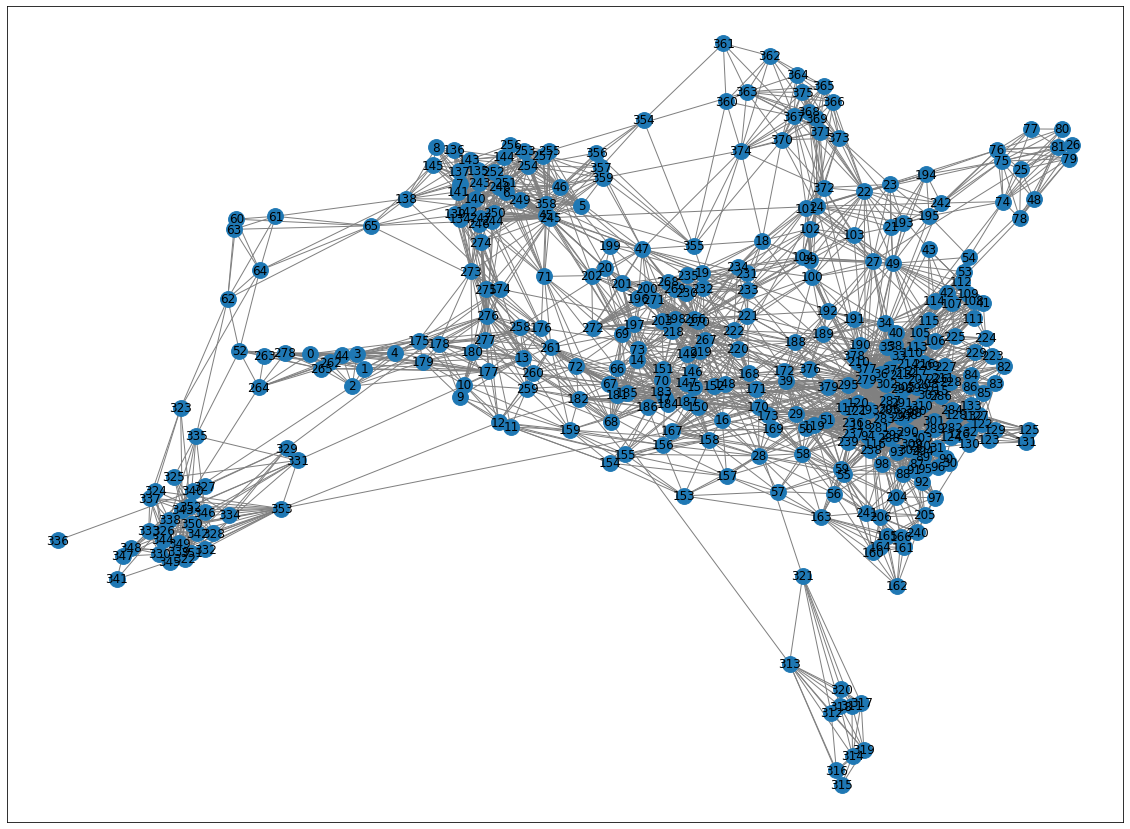

In [ ]:
#plot edges and nodes
plt.figure(figsize = (20, 15))
pos = nx.spring_layout(G)
edge_list = [edge for edge in G.edges()]
nx.draw_networkx_nodes(G,pos, cmap=plt.get_cmap('jet'),node_size = 250)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='gray', arrows=True)

In [ ]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
plt.hist(in_degrees, bins = 30)

AttributeError: ignored

In [ ]:
print("The average in degree of each of the nodes is: {}".format(round(sum(in_degrees)/len(in_degrees), 1)))

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize = (20, 10))
plt.hist(degrees, bins = 180)
plt.title("Histogram of node degrees")

In [ ]:
round(sum(degrees)/len(degrees), 1)

In [ ]:
out_degrees = [G.out_degree(n) for n in G.nodes()]
plt.hist(out_degrees, bins = 30)

In [ ]:
print("The average out degree of each of the nodes is: {}".format(round(sum(out_degrees)/len(out_degrees), 1)))

In [ ]:
adj = nx.adjacency_matrix(G)